<a href="https://colab.research.google.com/github/seon03/ArtificialIntelligence/blob/main/(%EB%AA%A8%EB%8D%B8%20%EC%B5%9C%EC%A0%81%ED%99%94%20%EB%B0%8F%20%EA%B2%BD%EB%9F%89%ED%99%94)_Unstructured_Pruning_%E1%84%80%E1%85%AE%E1%84%92%E1%85%A7%E1%86%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (기본-1) Unstructured Pruning 구현

아래 설명과 코드를 쭉 읽어보면서 실제로 2강에서 배운 unstructured pruning을 수행하는 과정을 익혀봅시다.

그 후, 직접 사용해서 모델을 경량화를 해보겠습니다.

`TODO`라고 적혀있는곳을 모두 채워 넣는 것이 이 과제의 목표입니다.

## 목표

* 간단한 MLP 모델 구현 및 학습
* 중간 레이어 하나를 대상으로 unstructured pruning 구현

## 기본사항

* 데이터셋:
  * 좌표 점에 대한 이진 분류 가상 데이터
  * MNIST
* 기반 모델: MLP
* pruning 수행 방식: 중간 레이어에 대한 unstructured pruning

---

## 준비

### 작동 기준 라이브러리 버전

```
torch==2.4.0
torchvision==0.19.0
```

---

# Case 1: 간단한 pruning 예시

직접 생성한 작은 데이터셋에서, 작은 모델을 만들어서 unstructured pruning을 수행하는 예시를 먼저 살펴봅시다.

## 데이터 생성

In [ ]:
# 데이터 생성용 라이브러리들입니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 데이터 생성기
def generate_data(num_samples, turbulance=0.1):
    data = []
    num0 = 0
    num1 = 0
    while len(data) < num_samples:

        # [-2, 2)에서 랜덤한 좌표값 샘플
        x = 4 * np.random.random() - 2
        y = 4 * np.random.random() - 2

        # 중심이 (0, 0)이고 반지름 1 미만의 원 안에 있는 점이면 0, 밖에 있으면 1로 분류
        error = turbulance * (np.random.random() - 0.5)  # 학습 데이터는 오류를 가정
        if x * x + y * y < 1 + error:
            if num0 < num_samples // 2:
                c = 0
                num0 += 1
            else:
                continue
        else:
            if num1 < num_samples // 2:
                c = 1
                num1 += 1
            else:
                continue

        data.append((x, y, c))
    return data

In [ ]:
# 학습용 데이터
np.random.seed(42)
train_data = generate_data(num_samples=1000, turbulance=0.1)

In [ ]:
# 테스트용 데이터
np.random.seed(4242)
test_data = generate_data(num_samples=100, turbulance=0)

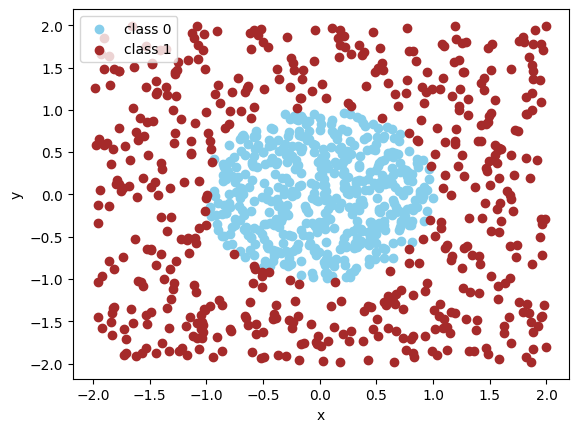

In [ ]:
# 실제로 생성된 데이터를 시각화 해봅시다

# DataFrame으로 만들고
df = pd.DataFrame(train_data, columns=['x', 'y', 'c'])

# class가 0, 1인 row들을 각각 가져와서
df0 = df[df['c'] == 0]
df1 = df[df['c'] == 1]

# 색상을 달리 해서 뿌리기
plt.scatter(df0['x'], df0['y'], color='skyblue', label='class 0')
plt.scatter(df1['x'], df1['y'], color='brown', label='class 1')

# 그래프 옵션 설정
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# 출력
plt.show()

## 모델

In [ ]:
# 딥러닝용 라이브러리도 import 합니다.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune

In [ ]:
# 항상 같은 결과가 나오도록 고정해주는 친구입니다. 지금은 무시하셔도 됩니다.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# 좌표를 받아서 두 클래스로 분류해주는 2-layer MLP 모델
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

## 학습

In [ ]:
# 모델 학습 함수
def train(model, data, device):
    ce_losser = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    model.train()
    for epoch in range(10):
        running_loss = 0.0
        for x, y, c in iter(data):
            inputs = torch.tensor([x, y]).to(device)
            labels = torch.tensor(c).to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = ce_losser(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'[Epoch {epoch + 1:2d}] Loss: {running_loss / len(train_data):8.5f}')

In [ ]:
# 테스트 함수
def test(model, data, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y, c in iter(data):
            inputs = torch.tensor([x, y]).to(device)
            labels = torch.tensor(c).to(device)
            logits = model(inputs)
            _, predicted = torch.max(logits.data, 0)
            total += 1
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:5.2f}%')

In [ ]:
# 모델 인스턴스 생성 및 학습
torch.manual_seed(42)
model = Model()
train(model, train_data, device)

[Epoch  1] Loss:  0.58154
[Epoch  2] Loss:  0.51865
[Epoch  3] Loss:  0.42586
[Epoch  4] Loss:  0.33426
[Epoch  5] Loss:  0.27084
[Epoch  6] Loss:  0.22679
[Epoch  7] Loss:  0.19240
[Epoch  8] Loss:  0.16873
[Epoch  9] Loss:  0.15043
[Epoch 10] Loss:  0.13655


In [ ]:
# 성능 평가
test(model, test_data, device)

Accuracy: 91.00%


In [ ]:
# 전체 파라미터 수
total_params = sum(p.numel() for p in model.parameters())

# 0이 아닌 파라미터의 수
total_params_nz = sum((p != 0.0).sum() for p in model.parameters())

# 0이 아닌 파라미터의 비율
print(f"non-zero portion: {100 * total_params_nz / total_params:6.02f}%")

non-zero portion: 100.00%


## Random Pruning

In [ ]:
# 이 데이터셋에 비해서 모델이 너무 복잡하니까 pruning을 해줍시다.
# pruning 대상은 첫번째 레이어(fc1)입니다.
layer = model.fc1
layer.weight  # 학습된 파라미터값 확인 (fc1의 세부 파라미터 'weight'과 'bias' 중 'weight'만 대상)

Parameter containing:
tensor([[ 0.4882,  1.2030],
        [-0.6999,  1.0665],
        [-0.0888,  0.0814],
        [-1.5433, -0.2316],
        [ 0.0636, -1.4266],
        [ 0.9359, -0.1400],
        [ 0.8849,  0.2421],
        [ 0.5310, -0.3317],
        [ 0.8150, -0.1400],
        [-0.2739,  0.1223]], device='cuda:0', requires_grad=True)

In [ ]:
# PyTorch의 prune 라이브러리를 사용해서 대상 layer에서 랜덤하게 50%의 파라미터를 제거
torch.manual_seed(42)
prune.random_unstructured(layer, name='weight', amount=0.5)
layer.weight  # 제거된(0으로 바뀐) 파라미터 확인

tensor([[ 0.0000,  1.2030],
        [-0.0000,  1.0665],
        [-0.0888,  0.0000],
        [-0.0000, -0.0000],
        [ 0.0000, -1.4266],
        [ 0.9359, -0.0000],
        [ 0.0000,  0.2421],
        [ 0.5310, -0.3317],
        [ 0.0000, -0.1400],
        [-0.0000,  0.1223]], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
# pruning 직후의 성능 측정
test(model, test_data, device)

Accuracy: 72.00%


In [ ]:
# 다시 학습 데이터에 fine-tuning
train(model, train_data, device)

[Epoch  1] Loss:  0.36546
[Epoch  2] Loss:  0.29979
[Epoch  3] Loss:  0.29149
[Epoch  4] Loss:  0.28824
[Epoch  5] Loss:  0.28603
[Epoch  6] Loss:  0.28429
[Epoch  7] Loss:  0.28301
[Epoch  8] Loss:  0.28195
[Epoch  9] Loss:  0.28115
[Epoch 10] Loss:  0.28049


In [ ]:
# fine-tuning 이후의 성능 테스트
test(model, test_data, device)

Accuracy: 90.00%


In [ ]:
# 제거된 파라미터가 여전히 0인지 확인
layer.weight

tensor([[ 0.0000,  1.2630],
        [-0.0000,  1.1218],
        [-0.0888,  0.0000],
        [-0.0000, -0.0000],
        [ 0.0000, -1.5432],
        [ 1.1556, -0.0000],
        [ 0.0000,  0.2421],
        [ 0.8259, -0.1079],
        [ 0.0000, -0.1400],
        [-0.0000,  0.1223]], device='cuda:0')

In [ ]:
# pruning 결과를 실제로 반영 (PyTorch의 구현 방식상 필요)
prune.remove(layer, 'weight')

Linear(in_features=2, out_features=10, bias=True)

In [ ]:
# 0이 아닌 파라미터의 비율
total_params = sum(p.numel() for p in model.parameters())
total_params_nz = sum((p != 0.0).sum() for p in model.parameters())
print(f"non-zero portion: {100 * total_params_nz / total_params:5.02f}%")

non-zero portion: 80.77%


In [ ]:
# 레이어별로 살펴보기
for name, p in model.named_parameters():
    num_params = p.numel()
    num_params_nz = int((p != 0.0).sum())
    print(f"{name}\t{num_params_nz:2d}/{num_params:2d}")

fc1.bias	10/10
fc1.weight	10/20
fc2.weight	20/20
fc2.bias	 2/ 2


## Magnitude Pruning (1)

In [ ]:
# 다른 방법으로 pruning을 해보기 위해 모델을 다시 준비합시다.
torch.manual_seed(42)
model = Model()
train(model, train_data, device)
test(model, test_data, device)

[Epoch  1] Loss:  0.58154
[Epoch  2] Loss:  0.51865
[Epoch  3] Loss:  0.42586
[Epoch  4] Loss:  0.33426
[Epoch  5] Loss:  0.27084
[Epoch  6] Loss:  0.22679
[Epoch  7] Loss:  0.19240
[Epoch  8] Loss:  0.16873
[Epoch  9] Loss:  0.15043
[Epoch 10] Loss:  0.13655
Accuracy: 91.00%


In [ ]:
# 이번엔 랜덤하게가 아니라, 파라미터 크기가 작은 순으로 제거
layer = model.fc1
prune.l1_unstructured(layer, name='weight', amount=0.5)

Linear(in_features=2, out_features=10, bias=True)

In [ ]:
# 제거 직후에 다시 테스트, 성능 저하 거의 없음!
test(model, test_data, device)

Accuracy: 91.00%


In [ ]:
# 여기서 fine-tuning을 수행
train(model, train_data, device)
test(model, test_data, device)

[Epoch  1] Loss:  0.13803
[Epoch  2] Loss:  0.12350
[Epoch  3] Loss:  0.11598
[Epoch  4] Loss:  0.10990
[Epoch  5] Loss:  0.10462
[Epoch  6] Loss:  0.10009
[Epoch  7] Loss:  0.09612
[Epoch  8] Loss:  0.09265
[Epoch  9] Loss:  0.08953
[Epoch 10] Loss:  0.08676
Accuracy: 93.00%


In [ ]:
# 0이 아닌 파라미터의 비율
prune.remove(layer, 'weight')
total_params = sum(p.numel() for p in model.parameters())
total_params_nz = sum((p != 0.0).sum() for p in model.parameters())
print(f"non-zero portion: {100 * total_params_nz / total_params:5.02f}%")

non-zero portion: 80.77%


## Magnitude Pruning (2)

In [ ]:
# 다른 레이어에 대해서 pruning을 해보기 위해 모델을 다시 준비합시다.
torch.manual_seed(42)
model = Model()
train(model, train_data, device)
test(model, test_data, device)

[Epoch  1] Loss:  0.58154
[Epoch  2] Loss:  0.51865
[Epoch  3] Loss:  0.42586
[Epoch  4] Loss:  0.33426
[Epoch  5] Loss:  0.27084
[Epoch  6] Loss:  0.22679
[Epoch  7] Loss:  0.19240
[Epoch  8] Loss:  0.16873
[Epoch  9] Loss:  0.15043
[Epoch 10] Loss:  0.13655
Accuracy: 91.00%


In [ ]:
# 이번엔 fc1.weight가 아니라 fc2.weight를 pruning 할 것입니다.
layer = model.fc2
prune.l1_unstructured(layer, name='weight', amount=0.5)

Linear(in_features=10, out_features=2, bias=True)

In [ ]:
# 제거 직후에 다시 테스트
test(model, test_data, device)

Accuracy: 82.00%


In [ ]:
# 이어서 fine-tuning을 수행
train(model, train_data, device)
test(model, test_data, device)

[Epoch  1] Loss:  0.19062
[Epoch  2] Loss:  0.14507
[Epoch  3] Loss:  0.13268
[Epoch  4] Loss:  0.12412
[Epoch  5] Loss:  0.11701
[Epoch  6] Loss:  0.11076
[Epoch  7] Loss:  0.10550
[Epoch  8] Loss:  0.10091
[Epoch  9] Loss:  0.09688
[Epoch 10] Loss:  0.09340
Accuracy: 92.00%


In [ ]:
# 0이 아닌 파라미터의 비율
prune.remove(layer, 'weight')
total_params = sum(p.numel() for p in model.parameters())
total_params_nz = sum((p != 0.0).sum() for p in model.parameters())
print(f"non-zero portion: {100 * total_params_nz / total_params:5.02f}%")

non-zero portion: 80.77%


## Magnitude Pruning (3)

In [ ]:
# 이번엔 pruning 비율을 달리 해보기 위해 모델을 다시 준비합시다.
torch.manual_seed(42)
model = Model()
train(model, train_data, device)
test(model, test_data, device)

[Epoch  1] Loss:  0.58154
[Epoch  2] Loss:  0.51865
[Epoch  3] Loss:  0.42586
[Epoch  4] Loss:  0.33426
[Epoch  5] Loss:  0.27084
[Epoch  6] Loss:  0.22679
[Epoch  7] Loss:  0.19240
[Epoch  8] Loss:  0.16873
[Epoch  9] Loss:  0.15043
[Epoch 10] Loss:  0.13655
Accuracy: 91.00%


In [ ]:
# 이번엔 fc1.weight에서 80%를 제거할 것입니다.
layer = model.fc1
prune.l1_unstructured(layer, name='weight', amount=0.8)

Linear(in_features=2, out_features=10, bias=True)

In [ ]:
# 제거 직후에 다시 테스트
test(model, test_data, device)

Accuracy: 76.00%


In [ ]:
# 이어서 fine-tuning을 수행
train(model, train_data, device)
test(model, test_data, device)

[Epoch  1] Loss:  0.36777
[Epoch  2] Loss:  0.32191
[Epoch  3] Loss:  0.31416
[Epoch  4] Loss:  0.31049
[Epoch  5] Loss:  0.30760
[Epoch  6] Loss:  0.30513
[Epoch  7] Loss:  0.30321
[Epoch  8] Loss:  0.30157
[Epoch  9] Loss:  0.29971
[Epoch 10] Loss:  0.29821
Accuracy: 84.00%


In [ ]:
# 0이 아닌 파라미터의 비율
prune.remove(layer, 'weight')
total_params = sum(p.numel() for p in model.parameters())
total_params_nz = sum((p != 0.0).sum() for p in model.parameters())
print(f"non-zero portion: {100 * total_params_nz / total_params:5.02f}%")

non-zero portion: 69.23%


---

# Case 2: MNIST

이번엔 MNIST 데이터셋에서, 조금 더 큰 모델에 대해 직접 unstructured pruning을 해봅시다.

## MNIST 데이터셋

* 개요
    * 손으로 쓴 숫자 이미지가 각각 어떤 숫자인지 (0~9) 분류하는 task
    * 입력: 28x28 사이즈의 흑백 이미지
    * 출력: 0 ~ 9

* copyright
    * [링크](https://yann.lecun.com/exdb/mnist/) 참고

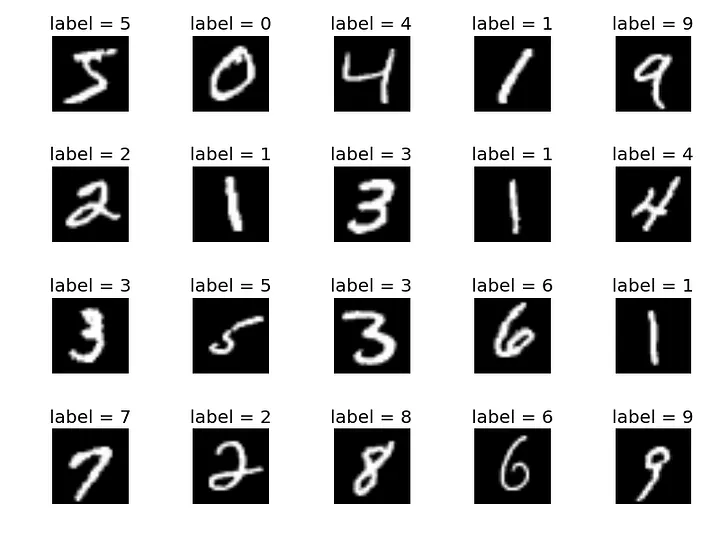

In [ ]:
# 추가 라이브러리
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

In [ ]:
# MNIST 데이터셋을 다운받아둡시다.
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.68MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 이번엔 DataLoader를 사용합니다. 데이터를 128개씩 묶음(batch)으로 불러와줍니다.
def get_dataloaders():
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    return train_loader, test_loader

## 모델 준비

In [ ]:
# 흑백 이미지를 받아서 10개 클래스로 분류해주는 3-layer MLP 모델
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # 28 by 28 픽셀을 784개의 값으로로 펼쳐서 사용합니다.
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

## 학습 준비

In [ ]:
# 모델 학습 함수
def train(model, train_loader, epochs, learning_rate, device):
    model.to(device)
    model.train()
    ce_losser = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in iter(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = ce_losser(input=logits, target=labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[Epoch {epoch + 1:2d}/{epochs:2d}] Loss: {running_loss / len(train_loader):8.5f}")

In [ ]:
# 테스트 함수
def test(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in iter(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model(inputs)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test 정확도: {accuracy:5.2f}%")
    return accuracy

In [ ]:
# 기본 모델 학습 및 테스트 진행
torch.manual_seed(42)
model = Net()
train_loader, test_loader = get_dataloaders()
train(model, train_loader, epochs=5, learning_rate=0.001, device=device)
accuracy = test(model, test_loader, device)

[Epoch  1/ 5] Loss:  0.30870
[Epoch  2/ 5] Loss:  0.11009
[Epoch  3/ 5] Loss:  0.07186
[Epoch  4/ 5] Loss:  0.05127
[Epoch  5/ 5] Loss:  0.03615
Test 정확도: 97.28%


In [ ]:
# TODO: 위에서 배운 pruning 함수를 이용해서 unstructured pruning을 수행합니다.
# 어떤 레이어를 얼만큼 하면 좋을지를 고민하고 실험해보세요 (다시 돌릴때는 위 블럭부터 초기화/재학습 시켜야합니다).
# 원래 모델의 성능보다 떨어지지 않으면서, 파라미터를 50% 미만으로 줄이는것이 목표입니다.
# --- fill below ---


# --- fill above ---

# pruning 후 fine-tuning은 5 epoch만 진행합니다
train(model, train_loader, epochs=5, learning_rate=0.001, device=device)
prune.remove(layer, 'weight')

[Epoch  1/ 5] Loss:  0.03031
[Epoch  2/ 5] Loss:  0.02050
[Epoch  3/ 5] Loss:  0.01774
[Epoch  4/ 5] Loss:  0.01682
[Epoch  5/ 5] Loss:  0.01222


ValueError: Parameter 'weight' of module Linear(in_features=2, out_features=10, bias=True) has to be pruned before pruning can be removed

In [ ]:
# 성능 측정
accuracy = test(model, test_loader, device)

# 0이 아닌 파라미터의 비율
total_params = sum(p.numel() for p in model.parameters())
total_params_nz = sum((p != 0.0).sum() for p in model.parameters())
print(f"non-zero portion: {100 * total_params_nz / total_params:5.02f}%")

## References

* [PyTorch Pruning Tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)

## 콘텐츠 라이선스

<font color='red'><b>**WARNING**</b></font>: **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.